In [ ]:
pip install arviz

In [ ]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import arviz
import pickle
import cmdstanpy
import json
import copy
import pandas as pd

In [ ]:
with open('/content/drive/MyDrive/TFM-Crowd learning/multinomial.json') as json_file:
    data = json.load(json_file)

In [ ]:
dades={'Tasca': data['t_A'], 'Worker': data['w_A'], 'Anotació': data['ann'] }
df = pd.DataFrame(data=dades)
df

,Tasca,Worker,Anotació
0,0,14,2
1,0,13,2
2,0,4,2
3,0,2,2
4,0,7,1
...,...,...,...
9995,999,17,2
9996,999,2,2
9997,999,13,2
9998,999,14,2


In [ ]:
sm_general = pystan.StanModel(file='/content/drive/MyDrive/TFM-Crowd learning/Fitxers STAN/general_dawid-skene.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b3b91d5d08ea08e32e8380bfec8b2a00 NOW.


In [ ]:
w = len(np.unique(df['Worker']))
t = len(np.unique(df['Tasca']))
a = len(df['Anotació'])
k = len(np.unique(df['Anotació']))
t_A = np.array(df['Tasca'])+1
w_A = np.array(df['Worker'])+1
ann = np.array(df['Anotació'])+1
tau_prior = np.array([1,1,1])
pi_prior = np.ones((k,k))

dades_sm_gen = {'w':w,'t':t,'a':a,'k':k,'t_A':t_A,'w_A':w_A,'ann':ann,'tau_prior':tau_prior,'pi_prior':pi_prior} 

In [ ]:
pi_ini = np.zeros((w,k,k))
for yw in range(w):
  pi_ini[yw] = np.eye(k)+0.05
  pi_ini[yw] /= np.sum(pi_ini[yw],axis=1)
dades_inicials_gen = {'pi':pi_ini}

In [ ]:
optim = sm_general.optimizing(data=dades_sm_gen,init=dades_inicials_gen)
optim

OrderedDict([('tau', array([0.11255439, 0.29707807, 0.59036754])),
             ('pi', array([[[0.85030393, 0.07912402, 0.07057205],
                      [0.2190914 , 0.58873216, 0.19217643],
                      [0.14764806, 0.09130008, 0.76105187]],
              
                     [[0.65428744, 0.12651689, 0.21919568],
                      [0.30767997, 0.51725506, 0.17506497],
                      [0.13056934, 0.11073742, 0.75869324]],
              
                     [[0.62411089, 0.08478025, 0.29110886],
                      [0.21375239, 0.60219209, 0.18405553],
                      [0.07409223, 0.10849206, 0.8174157 ]],
              
                     [[0.69221724, 0.09323093, 0.21455183],
                      [0.19745893, 0.63426118, 0.16827989],
                      [0.09578798, 0.13825148, 0.76596054]],
              
                     [[0.55527261, 0.16266821, 0.28205918],
                      [0.22260538, 0.63068554, 0.14670908],
                      [

In [ ]:
sm_gener_data = pystan.StanModel(file='/content/drive/MyDrive/TFM-Crowd learning/Fitxers STAN/generate_data.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8251fcac44b8988cc03b6a3bfb75909e NOW.


## Functions

In [ ]:
import random 
from scipy.stats import entropy

def generate_new_data(opt,k):
  results = opt['ann']-1
  results=np.where(results<0,np.nan,results)
  diction = {}
  for i in range(k):
    diction["where_{0}_task".format(i)] = np.where(results==i)[0]
    diction["where_{0}_worker".format(i)] = np.where(results==i)[1]
    diction["annotation_{0}".format(i)] = np.full(len(diction["where_{0}_task".format(i)]), fill_value=i, dtype = np.int)
  tasks_col = np.concatenate([diction["where_{0}_task".format(i)] for i in range(k)])
  workers_col = np.concatenate([diction["where_{0}_worker".format(i)] for i in range(k)])
  annotatios_col = np.concatenate([diction["annotation_{0}".format(i)] for i in range(k)])
  d = {'Tasca': tasks_col, 'Worker': workers_col, 'Anotació':annotatios_col}
  return pd.DataFrame(d).sort_values(by='Tasca')

def generate_permutation(perm):
    l=list(perm)
    uniques=[k for k in l if l.count(k)==1]
    if len(uniques)==len(l): 
      return np.array(l)
    existing=list(set(l))
    rank=list(range(len(l)))
    missing=[x for x in rank if x not in existing]
    corrected=[]
    for k in range(len(l)):
        if l[k] not in uniques:
            if l[k] not in corrected:
                if l[l[k]]==l[k]:
                    if k!=l[k]:
                        l[k]=missing[0]
                        missing.pop(0)
                    else:
                        corrected.append(l[k])
                else:
                    corrected.append(l[k])
            else:
                l[k]=missing[0]
                missing.pop(0)
        else:
          continue
    return np.array(l)

def pipeline(t,ann_per_task,tau,pi,tau_prior,pi_prior,sm_generate = sm_gener_data,sm2 = sm_general ):
  w = pi.shape[0]
  k = pi.shape[1]
  workers_random_order = []
  for i in range(t):
    workers=np.arange(1,w+1)
    random.shuffle(workers)
    workers_random_order.append(workers)
  data_to_pass = {'w':w,'t':t,'k':k,'tau':tau,'ann_per_task':ann_per_task,'workers_random_order':workers_random_order,'pi':pi} 
  generated_data = sm_generate.optimizing(data=data_to_pass)
  generated_data_df = generate_new_data(generated_data,k)
  a = len(generated_data_df['Anotació'])
  t_A = np.array(generated_data_df['Tasca'])+1
  w_A = np.array(generated_data_df['Worker'])+1
  ann = np.array(generated_data_df['Anotació'])+1
  data_to_pass_2 = {'w':w,'t':t,'a':a,'k':k,'t_A':t_A,'w_A':w_A,'ann':ann,'tau_prior':tau_prior,'pi_prior':pi_prior} 
  params = sm2.optimizing(data=data_to_pass_2)
  return params

def kullback_leibler_tau(tau_init,tau_hat):
  entrop = entropy(pk = tau_init, qk = tau_hat)
  if entrop == np.nan or entrop == np.inf: #should never enter here
    return 100 
  else:
    return entrop

def kullback_leibler_pi(pi_init,pi_hat):
  KL_values = []
  for i in range(len(pi_init)):
    entrop = entropy(pk = pi_init[i], qk = pi_hat[i])
    if np.isinf(entrop).all() ==True or np.isnan(entrop).all()==True:  #should never enter here
      continue
    KL_values.append(np.nanmax(entrop[entrop != np.inf]))
  
  if not KL_values: #if array is empty
    return 100 #case where it has worked horrible, should never enter here
  else:
    return np.nanmedian(KL_values)


def correct_label_switching(tau,pi):
  acumulacio_permutacions=[]

  new_pi = copy.deepcopy(pi)
  new_tau = copy.deepcopy(tau)


  for w in range(len(pi)):
    on_hauria_danar = np.argmax(pi[w],axis=1)
    acumulacio_permutacions.append(on_hauria_danar)

  #we determine the winner permutation in order to apply it to tau and pi
  values, counts = np.unique(acumulacio_permutacions,axis=0, return_counts=True)
  ind = np.argmax(counts)
  permutacio = values[ind]

  #fix (if necessary) the obtained permutation (the result is an array!)
  good_permutation = generate_permutation(permutacio)

  #update pi
  for w in range(len(pi)):
    new_pi[w,good_permutation,:] = pi[w,np.arange(len(pi[w])),:]

  #update tau
  for i in range(len(tau)):
    new_tau[good_permutation[i]] = tau[i]

  return new_tau,new_pi


def get_KL_values(tau,pi,exp):
  exps =  copy.deepcopy(exp)
  tau_hat = exps['tau']
  pi_hat = exps['pi']
  KL_tau_no_LS = kullback_leibler_tau(tau,tau_hat)
  KL_pi_no_LS = kullback_leibler_pi(pi,pi_hat)
  new_tau_hat,new_pi_hat = correct_label_switching(tau_hat,pi_hat)
  KL_tau_LS = kullback_leibler_tau(tau,new_tau_hat)
  KL_pi_LS = kullback_leibler_pi(pi,new_pi_hat)
  return KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS

def experiment_repetition(t,ann_per_task,tau,pi,tau_prior,pi_prior,num_repetitions=500):
  KL_tau_no_LS_values=[]
  KL_pi_no_LS_values=[]
  KL_tau_LS_values=[]
  KL_pi_LS_values=[]
  for i in range(num_repetitions):
    exp = pipeline(t,ann_per_task,tau,pi,tau_prior,pi_prior)
    KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS = get_KL_values(tau,pi,exp)
    KL_tau_no_LS_values.append(KL_tau_no_LS)
    KL_pi_no_LS_values.append(KL_pi_no_LS)
    KL_tau_LS_values.append(KL_tau_LS)
    KL_pi_LS_values.append(KL_pi_LS)
  return KL_tau_no_LS_values,KL_pi_no_LS_values,KL_tau_LS_values,KL_pi_LS_values



## Data from multinomial.json



In [ ]:
#PIPELINE CELL
k = len(np.unique(df['Anotació']))
tau_prior = np.full(shape=k,fill_value=1)
pi_prior = np.ones((k,k))
KL_tau_no_LS_values=[]
KL_pi_no_LS_values=[]
KL_tau_LS_values=[]
KL_pi_LS_values=[]

for i in range(6,22,2):
  print(i)
  KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS= experiment_repetition(t=len(np.unique(df['Tasca'])),ann_per_task=i,tau=optim['tau'],pi=optim['pi'],tau_prior = tau_prior,pi_prior=pi_prior)
  KL_tau_no_LS_values.append(KL_tau_no_LS)
  KL_pi_no_LS_values.append(KL_pi_no_LS)
  KL_tau_LS_values.append(KL_tau_LS)
  KL_pi_LS_values.append(KL_pi_LS)

KL_tau_no_LS_values = np.array(KL_tau_no_LS_values)
KL_pi_no_LS_values = np.array(KL_pi_no_LS_values)
KL_tau_LS_values = np.array(KL_tau_LS_values)
KL_pi_LS_values = np.array(KL_pi_LS_values)

In [ ]:
#save values in txt file
file_KL_tau_no_LS_values = open("data_from_multinomial_json_KL_tau_no_LS_values.txt", "w")
for row in KL_tau_no_LS_values:
  np.savetxt(file_KL_tau_no_LS_values, row)

file_KL_tau_no_LS_values.close()

file_KL_pi_no_LS_values = open("data_from_multinomial_json_KL_pi_no_LS_values.txt", "w")
for row in KL_pi_no_LS_values:
  np.savetxt(file_KL_pi_no_LS_values, row)

file_KL_pi_no_LS_values.close()


file_KL_tau_LS_values = open("data_from_multinomial_json_KL_tau_LS_values.txt", "w")
for row in KL_tau_LS_values:
  np.savetxt(file_KL_tau_LS_values, row)

file_KL_tau_LS_values.close()

file_KL_pi_LS_values = open("data_from_multinomial_json_KL_pi_LS_values.txt", "w")
for row in KL_pi_LS_values:
  np.savetxt(file_KL_pi_LS_values, row)

file_KL_pi_LS_values.close()



In [ ]:
from google.colab import files
files.download('data_from_multinomial_json_KL_tau_no_LS_values.txt')
files.download('data_from_multinomial_json_KL_pi_no_LS_values.txt')
files.download('data_from_multinomial_json_KL_tau_LS_values.txt')
files.download('data_from_multinomial_json_KL_pi_LS_values.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#to recover the arrays from the txt files, compile this:
#FOR THE SHAPES, SEE THE prints from the pipeline CELL, but it is basically (len(np.unique(ann_per_task)),t)
original_KL_tau_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/data_from_multinomial_json_KL_tau_no_LS_values.txt").reshape(8, 500)
original_KL_pi_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/data_from_multinomial_json_KL_pi_no_LS_values.txt").reshape(8,500)
original_KL_tau_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/data_from_multinomial_json_KL_tau_LS_values.txt").reshape(8,500)
original_KL_pi_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/data_from_multinomial_json_KL_pi_LS_values.txt").reshape(8,500)

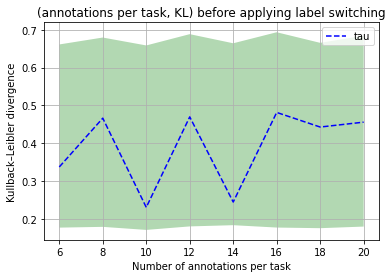

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_no_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau BEFORE LS', np.mean(np.nanmedian(KL_tau_no_LS_values,axis=1)))

Mean value of the KL values for tau BEFORE LS 0.3909576953345755


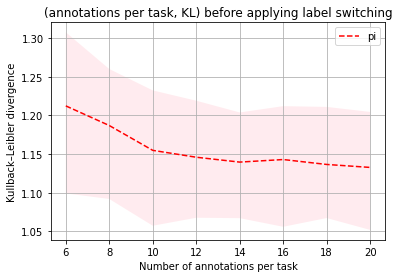

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_no_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi BEFORE LS', np.mean(np.nanmedian(KL_pi_no_LS_values,axis=1)))

Mean value of the KL values for pi BEFORE LS 1.156477396836359


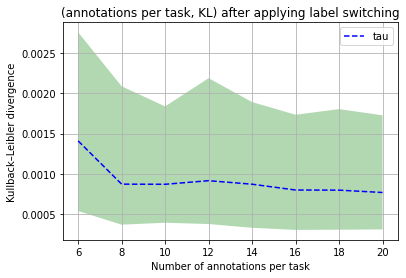

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_tau_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_tau_LS_values, 25,axis=1),y2=np.percentile(KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau AFTER LS', np.mean(np.nanmedian(KL_tau_LS_values,axis=1)))

Mean value of the KL values for tau AFTER LS 0.000912804582351748


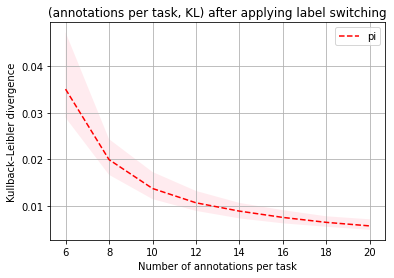

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(KL_pi_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(KL_pi_LS_values, 25,axis=1),y2=np.percentile(KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi AFTER LS', np.mean(np.nanmedian(KL_pi_LS_values,axis=1)))

Mean value of the KL values for pi AFTER LS 0.013486506767889577


Combined plots:

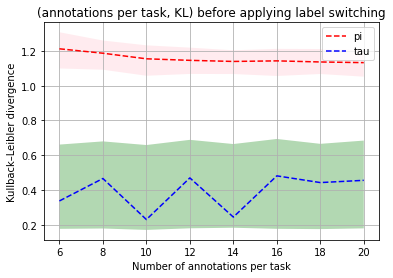

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_no_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_no_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['pi','tau'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

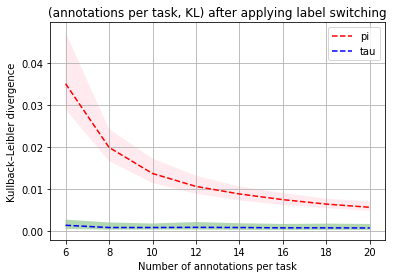

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=22,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_LS_values,axis=1),'r--')
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['pi','tau'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

## Paid crowd from the article

In [ ]:
#PIPELINE CELL
k=5
num_workers=50
tau_prior = np.full(shape=k,fill_value=1)
pi_prior = np.ones((k,k))

tau = np.random.dirichlet([15,15,15,15,15])
pi=np.zeros((num_workers,k,k))

for w in range(num_workers):
  matriu_randoms_dirichlet = np.array([[37,11,7,12,33],
                                      [17,40,16,12,15],
                                      [6,5,27,31,31],
                                      [5,3,19,31,42],
                                      [2,1,5,19,73]])
  for i in range(k):
    pi[w][i] += np.random.dirichlet(matriu_randoms_dirichlet[i])


KL_tau_no_LS_values=[]
KL_pi_no_LS_values=[]
KL_tau_LS_values=[]
KL_pi_LS_values=[]

for i in range(6,38,2):
  print(i)
  KL_tau_no_LS,KL_pi_no_LS,KL_tau_LS,KL_pi_LS = experiment_repetition(t=800,ann_per_task=i,tau=tau,pi=pi,tau_prior = tau_prior,pi_prior=pi_prior)
  KL_tau_no_LS_values.append(KL_tau_no_LS)
  KL_pi_no_LS_values.append(KL_pi_no_LS)
  KL_tau_LS_values.append(KL_tau_LS)
  KL_pi_LS_values.append(KL_pi_LS)

KL_tau_no_LS_values = np.array(KL_tau_no_LS_values)
KL_pi_no_LS_values = np.array(KL_pi_no_LS_values)
KL_tau_LS_values = np.array(KL_tau_LS_values)
KL_pi_LS_values = np.array(KL_pi_LS_values)


In [ ]:
#save values in txt file
file_KL_tau_no_LS_values = open("paid_crowd_tau_dirichlet_15_KL_tau_no_LS_values.txt", "w")
for row in KL_tau_no_LS_values:
  np.savetxt(file_KL_tau_no_LS_values, row)

file_KL_tau_no_LS_values.close()

file_KL_pi_no_LS_values = open("paid_crowd_tau_dirichlet_15_KL_pi_no_LS_values.txt", "w")
for row in KL_pi_no_LS_values:
  np.savetxt(file_KL_pi_no_LS_values, row)

file_KL_pi_no_LS_values.close()


file_KL_tau_LS_values = open("paid_crowd_tau_dirichlet_15_tau_LS_values.txt", "w")
for row in KL_tau_LS_values:
  np.savetxt(file_KL_tau_LS_values, row)

file_KL_tau_LS_values.close()

file_KL_pi_LS_values = open("paid_crowd_tau_dirichlet_15_KL_pi_LS_values.txt", "w")
for row in KL_pi_LS_values:
  np.savetxt(file_KL_pi_LS_values, row)

file_KL_pi_LS_values.close()


In [ ]:
from google.colab import files
files.download('paid_crowd_tau_dirichlet_15_KL_tau_no_LS_values.txt')
files.download('paid_crowd_tau_dirichlet_15_KL_pi_no_LS_values.txt')
files.download('paid_crowd_tau_dirichlet_15_tau_LS_values.txt')
files.download('paid_crowd_tau_dirichlet_15_KL_pi_LS_values.txt')

In [ ]:
#to recover the arrays from the txt files, compile this:
#FOR THE SHAPES, SEE THE prints from the pipeline CELL
original_KL_tau_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/paid_crowd_tau_dirichlet_15_KL_tau_no_LS_values.txt").reshape(16, 500)
original_KL_pi_no_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/paid_crowd_tau_dirichlet_15_KL_pi_no_LS_values.txt").reshape(16,500)
original_KL_tau_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/paid_crowd_tau_dirichlet_15_tau_LS_values.txt").reshape(16,500)
original_KL_pi_LS_values = np.loadtxt("/content/drive/MyDrive/TFM-Crowd learning/txt files/paid_crowd_tau_dirichlet_15_KL_pi_LS_values.txt").reshape(16,500)

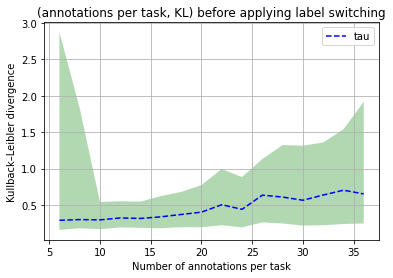

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_no_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_no_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau BEFORE LS', np.mean(np.nanmedian(original_KL_tau_no_LS_values,axis=1)))

Mean value of the KL values for tau BEFORE LS 0.459620574964252


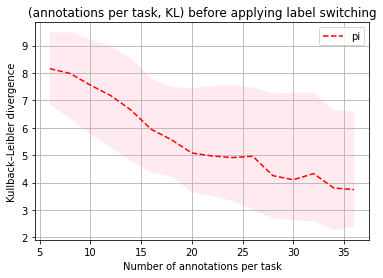

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_no_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) before applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_no_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_no_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi BEFORE LS', np.mean(np.nanmedian(original_KL_pi_no_LS_values,axis=1)))

Mean value of the KL values for pi BEFORE LS 5.575075331686551


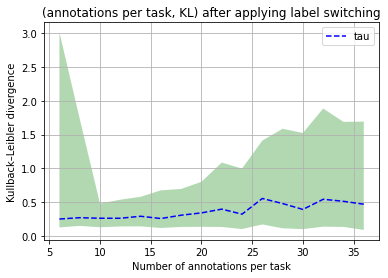

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_tau_LS_values,axis=1),'b--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['tau'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_tau_LS_values, 25,axis=1),y2=np.percentile(original_KL_tau_LS_values, 75,axis=1),alpha=0.3,facecolor='green')

plt.show()

In [ ]:
print('Mean value of the KL values for tau AFTER LS', np.mean(np.nanmedian(original_KL_tau_LS_values,axis=1)))

Mean value of the KL values for tau AFTER LS 0.3706050278644728


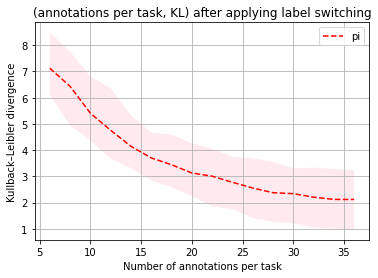

In [ ]:
import matplotlib.pyplot as plt
annots_x_task = np.arange(start=6,stop=38,step=2)
ax = plt.subplot()
plt.grid(True)
plt.plot(annots_x_task,np.nanmedian(original_KL_pi_LS_values,axis=1),'r--')
plt.xlabel('Number of annotations per task')
plt.ylabel('Kullback–Leibler divergence')
plt.title('(annotations per task, KL) after applying label switching')
plt.legend(['pi'])
ax.fill_between(annots_x_task,y1=np.percentile(original_KL_pi_LS_values, 25,axis=1),y2=np.percentile(original_KL_pi_LS_values, 75,axis=1),alpha=0.3,facecolor='pink')

plt.show()

In [ ]:
print('Mean value of the KL values for pi AFTER LS', np.mean(np.nanmedian(original_KL_pi_LS_values,axis=1)))

Mean value of the KL values for pi AFTER LS 3.602301717901088
